# **CVPS20 // Assignment 3**

assigned : **Oct 1, 2020**

DUE : **Oct 7, 2020 11:59pm**

## Characterizing the Fermi Haze/Bubbles

<img src="https://sci.esa.int/documents/34222/35279/1567216738403-Planck_GalacticHaze_Plus_Fermi_Bubbles_625.jpg" width=400x>

---

Our Galaxy is a fairly typical [spiral](https://en.wikipedia.org/wiki/Spiral_galaxy) galaxy with the Sun located about 8 kiloparsec from the Galactic center.  One of the consequences of that is that all-sky observations of the Universe beyond the Galaxy are always "contaminated" by the fact that telescopes must look through the Galaxy for certain pointings.  On the other hand, there is an entire field of astrophysics devoted to studying the Galactic interstellar medium ([ISM](https://en.wikipedia.org/wiki/Interstellar_medium)).  In 2009, the [Fermi Gamma-Ray Space Telescope](https://en.wikipedia.org/wiki/Fermi_Gamma-ray_Space_Telescope) released its first all-sky data of gamma-rays which allowed for an extremely detailed study of physical processes in the interstellar medium via gamma-ray emission.

In particular, gamma-rays in the ISM are produced in only a few ways, the most prominent being when protons, produced by exploding stars and flying through the Galaxy, slam into dust particles.  This creates particles called $\pi_0$'s that quickly decay into gamma-rays.  The next most prominent process is when electrons (also accelerated by exploding stars) smash into photons – e.g., produced by stars or left over from the Big Bang – and give them some of their energy, upscattering them to gamma-ray energies.  This process is called "Inverse Compton Scattering".  Note, these same electrons also produce synchrotron emission by spiraling around magnetic fields.

Thus, gamma-rays in the ISM "look like" dust because of the $\pi_0$ decay plus synchrotron because it is those same electrons that inverse Compton scatter low energy photons.  And so, also in 2009, we took sky-maps of dust emission and sky-maps synchrotron emission and fit those two "templates" to sky-maps of gamma-rays:

$ Fermi \ map = a_0 + a_1 \times dust \ map + a_2 \times synchrotron \ map$

When we removed this model from the original data, what we found in the residuals:

$ residuals = Fermi \ map - \left(a_0 + a_1 \times dust \ map + a_2 \times synchrotron \ map\right)$


was an enormous previously unknown structure in the Galaxy that looks like a giant "[Haze](https://iopscience.iop.org/article/10.1088/0004-637X/717/2/825/meta)" of gamma-rays towards the center of the Galaxy with sharp edges, giving it the shape of a pair of Fermi "[Bubbles](https://sci.esa.int/web/planck/-/50008-galactic-haze-and-bubbles)".  In this assignment, you will use techniques from class to uncover the Haze/Bubbles in the Fermi data, and determine how far off the Galactic plane that the bubbles stretch by finding their edges.

<b>

Rules for homeworks:

1. You may work with other students in the class, but if you do, each student with whom you worked <u>must</u> be listed in this notebook in the first cell below.  Direct copying from someone else's notebook is not permitted.

2. All solutions and outputs must be derived with python and the notebook should be "runable" by me (top to bottom) without errors.

3. Late homeworks will assess a 15% late penalty up to 3 days after the due date and a 50% late penalty until the end of the term (see CVPS20 syllabus).

</b>

<u>**Instructions for tasks that will be graded are in bold below.**</u>

---

**Please list the names of the other students with whom you worked for this assignment (if none, put "None").**

None

In [465]:
print('This assignment is being submitted approximately 35 minutes late. I had a lot of difficulty with the masking, and ended up using a different process')
print('I still am fairly confident this is not working well, since I am not getting good edge detection, but I wanted to turn something in before the midterm')
print('I plan on submitting this again, I am just not sure if it will be able to be in the 72 hour %15 late penalty that I am in now, or the %50 penalty')
print('and since I think this is above a %50 it is the safer option to turn this in now in case I cant get to it')

This assignment is being submitted approximately 28 minutes late. I had a lot of difficulty with the masking, and ended up using a different process
I still am fairly confident this is not working well, since I am not getting good edge detection, but I wanted to turn something in before the midterm
I plan on submitting this again, I am just not sure if it will be able to be in the 72 hour %15 late penalty that I am in now, or the %50 penalty
and since I think this is above a %50 it is the safer option to turn this in now in case I cant get to it


In [466]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as iio
import scipy.ndimage.measurements as snm
from scipy.ndimage.morphology import binary_dilation, binary_erosion, binary_closing, binary_opening

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gist_gray"

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In the `data/sky_maps` folder, you will find three all-sky maps stored as binary `numpy` files:

- `dust_map.npy`, a map of ISM dust emission

- `synch_map.npy`, a map of ISM synchrotron emission

- `fermi_gamma_rays.npy`, a map of ISM gamma-ray emission


**Load these maps into arrays using `numpy`'s `load()` function.**

In [14]:
cd /content/drive/My Drive/cvps20/data/sky_maps

/content/drive/My Drive/cvps20/data/sky_maps


In [467]:
dusty = np.load('dust_map.npy')
synchy = np.load('synch_map.npy')
fermi = np.load('fermi_gamma_rays.npy')

The linear combination described in the introduction is only a reasonable approximation for data away from the center of the Galactic plane.  Note that the coordinates of these maps are in *degrees* with the rows spanning $-90^{\circ}$ to $90^{\circ}$ (with the Galactic plane at $0^{\circ}$) and the columns spanning $-180^{\circ}$ to $180^{\circ}$.

**Make a `True/False` map that is True everywhere except within $12^{\circ}$ of the Galactic plane.  This will serve as a "mask" for the pixels that you will fit to the model.**

In [468]:
#720 rows, 1440 points (columns) in each
print(np.shape(dusty), np.shape(dusty[0]))
print('There are no negative values in dusty map')
print('The maps span 0 to 1, but this somehow corresponds to -90 to 90 degrees')
print('Make judgement call that 1 corresponds to maximum. So for rows, 1 is 90 degrees, 0 is -90 degrees, .5 is Galactic center')
print('each .1 step is 18 degrees, or alternatively each degree is .05555 units')
print('This is cut in doubled/halved for columns')
print('12 degrees row wise is then row values that are .066666 away from .5, or things below .43334, above .5666')
print('columns have each step being 36 degrees, or each degree being .027777 units')
print('12 degrees column wise is then things beyond .033333 away from .5, or things below .46666, .5333333')

(720, 1440) (1440,)
There are no negative values in dusty map
The maps span 0 to 1, but this somehow corresponds to -90 to 90 degrees
Make judgement call that 1 corresponds to maximum. So for rows, 1 is 90 degrees, 0 is -90 degrees, .5 is Galactic center
each .1 step is 18 degrees, or alternatively each degree is .05555 units
This is cut in doubled/halved for columns
12 degrees row wise is then row values that are .066666 away from .5, or things below .43334, above .5666
columns have each step being 36 degrees, or each degree being .027777 units
12 degrees column wise is then things beyond .033333 away from .5, or things below .46666, .5333333


In [469]:
print('I do not think i did the degree criterion correctly')
print('is it a coincidence that the rows go from 0 to 720, with a center at 360, and the columns are twice that, with a center at 720?')
print('e.g. each degree is 4 unit steps. 12 degrees is 48 steps in a circle')

I do not think i did the degree criterion correctly
is it a coincidence that the rows go from 0 to 720, with a center at 360, and the columns are twice that, with a center at 720?
e.g. each degree is 4 unit steps. 12 degrees is 48 steps in a circle


Notice that you can sub-select pixels from 2D arrays using 2D T/F masks as follows:

In [470]:
import numpy as np

# -- create a 2D array
np.random.seed(302)
arr = np.random.rand(7, 4)

# -- sub-select only pixels
mask = arr > 0.6
sub = arr[mask]

print("array:\n", arr)
print("\nmask:\n", mask)
print("\nsubset:\n", sub)

array:
 [[0.63628121 0.82504234 0.34164473 0.73963926]
 [0.46915689 0.54279063 0.54566657 0.13160125]
 [0.15321095 0.25664691 0.43813099 0.03926267]
 [0.76366469 0.82908592 0.24730551 0.06485819]
 [0.29212617 0.51390937 0.30581508 0.12724558]
 [0.49677133 0.41615909 0.94611686 0.84010232]
 [0.31051752 0.54799126 0.26512182 0.65660217]]

mask:
 [[ True  True False  True]
 [False False False False]
 [False False False False]
 [ True  True False False]
 [False False False False]
 [False False  True  True]
 [False False False  True]]

subset:
 [0.63628121 0.82504234 0.73963926 0.76366469 0.82908592 0.94611686
 0.84010232 0.65660217]


In [471]:
arr.shape, mask.shape

((7, 4), (7, 4))

In [473]:
#where I think i go wrong is the 12/180, but this method seems ok
cutoff_top = .5 + 12/180
cutoff_bot = .5 - 12/180
#things less than top and greater than bot are the galactic center points. everything within 12 degrees
mask_d = (dusty < cutoff_top) & (dusty > cutoff_bot)
#invert it
mask_d = np.invert(mask_d)
dusty_mask = dusty[mask_d]

print("array:\n", dusty)
print("\nmask:\n", mask_d)
print("\nsubset:\n", dusty_mask)

array:
 [[0.0003418  0.00034177 0.00034172 ... 0.00034286 0.0003428  0.00034277]
 [0.00034245 0.00034242 0.00034235 ... 0.00034358 0.00034352 0.00034349]
 [0.00034378 0.00034375 0.00034368 ... 0.00034508 0.00034501 0.00034497]
 ...
 [0.00060141 0.00060147 0.00060157 ... 0.00059922 0.00059934 0.00059941]
 [0.00057642 0.00057645 0.00057651 ... 0.00057514 0.00057521 0.00057525]
 [0.00056362 0.00056364 0.00056368 ... 0.00056277 0.00056282 0.00056285]]

mask:
 [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

subset:
 [0.0003418  0.00034177 0.00034172 ... 0.00056277 0.00056282 0.00056285]


In [474]:
cutoff_top = .5 + 12/180
cutoff_bot = .5 - 12/180
#things less than top and greater than bot are the galactic center points. everything within 12 degrees
mask_s = (synchy < cutoff_top) & (synchy > cutoff_bot)
#invert it
mask_s = np.invert(mask_s)
synchy_mask = synchy[mask_s]

print("array:\n", synchy)
print("\nmask:\n", mask_s)
print("\nsubset:\n", synchy_mask)

array:
 [[0.01387148 0.01387082 0.01386953 ... 0.01389415 0.01389298 0.01389237]
 [0.01381951 0.01381872 0.01381719 ... 0.01384644 0.01384504 0.01384432]
 [0.01371845 0.01371742 0.01371542 ... 0.01375351 0.01375169 0.01375075]
 ...
 [0.01445164 0.01445305 0.0144558  ... 0.01440351 0.01440601 0.01440731]
 [0.0143736  0.01437472 0.0143769  ... 0.01433512 0.01433713 0.01433817]
 [0.0143319  0.01433287 0.01433474 ... 0.01429869 0.01430042 0.01430132]]

mask:
 [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

subset:
 [0.01387148 0.01387082 0.01386953 ... 0.01429869 0.01430042 0.01430132]


In [475]:
cutoff_top = .5 + 12/180
cutoff_bot = .5 - 12/180
#things less than top and greater than bot are the galactic center points. everything within 12 degrees
mask_f = (fermi < cutoff_top) & (fermi > cutoff_bot)
#invert it
mask_f = np.invert(mask_f)
fermi_mask = fermi[mask_f]

print("array:\n", fermi)
print("\nmask:\n", mask_f)
print("\nsubset:\n", fermi_mask)

array:
 [[0.12495426 0.12495426 0.12495426 ... 0.12143441 0.12143441 0.12143441]
 [0.11965912 0.11973482 0.11981051 ... 0.12143441 0.12143441 0.12143441]
 [0.12180258 0.12198483 0.12216709 ... 0.12143441 0.12143441 0.12143441]
 ...
 [0.08470904 0.08477347 0.0848379  ... 0.08451575 0.08458018 0.08464461]
 [0.09493822 0.09497077 0.09500332 ... 0.09484056 0.09487311 0.09490566]
 [0.10693517 0.10693517 0.10693517 ... 0.10693517 0.10693517 0.10693517]]

mask:
 [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

subset:
 [0.12495426 0.12495426 0.12495426 ... 0.10693517 0.10693517 0.10693517]


In [476]:
y = np.arange(-90,90, 180/dusty.shape[0]) #degree bounds, pixel size
x = np.arange(-180,180,360/dusty.shape[1])
xx, yy = np.meshgrid(x, y, sparse=True)
dist = np.sqrt(xx**2 + yy**2)

boolean_array_in = np.logical_or(yy >= 12, yy <= -12)
boolean_array_out = np.logical_and(yy <= 12, yy >= -12)
in_range_indices = np.where(boolean_array_in)[0]
out_range_indices = np.where(boolean_array_out)[0]
print('True/False grid for indices outside 12 degrees (measured vertically, would use dist > 12 if I wanted to cut a sphere) is:')
print(boolean_array_in)

True/False grid for indices outside 12 degrees (measured vertically, would use dist > 12 if I wanted to cut a sphere) is:
[[ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ Tr

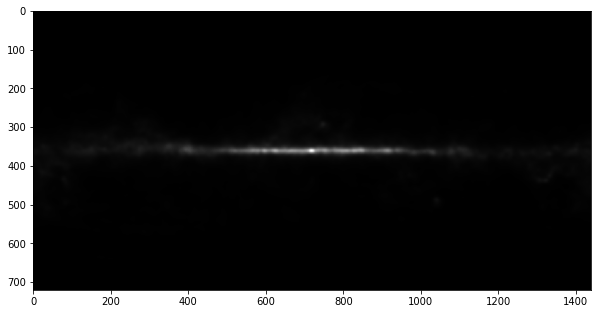

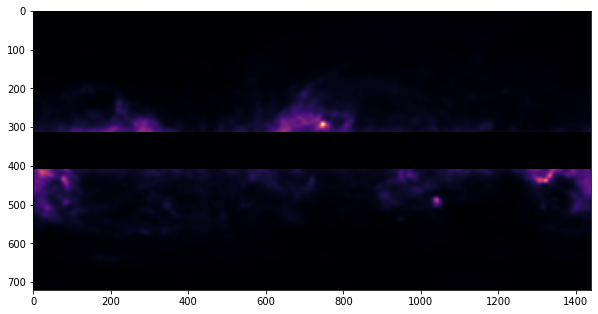

In [477]:
dusty_cut = dusty.copy()
dusty_cut[out_range_indices] = 0
plt.imshow(dusty)
plt.show()
plt.imshow(dusty_cut, cmap = 'magma')
plt.show()

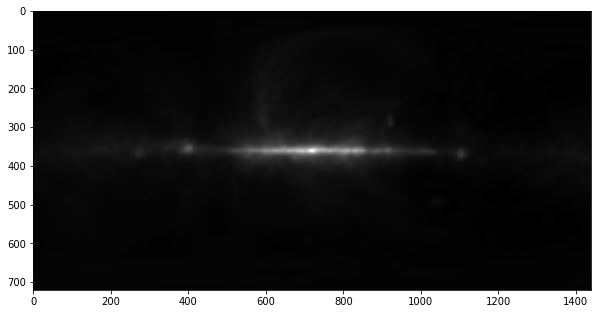

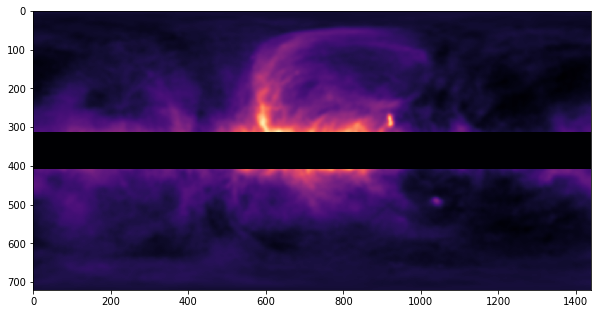

In [478]:
synchy_cut = synchy.copy()
synchy_cut[out_range_indices] = 0
plt.imshow(synchy)
plt.show()
plt.imshow(synchy_cut, cmap = 'magma')
plt.show()

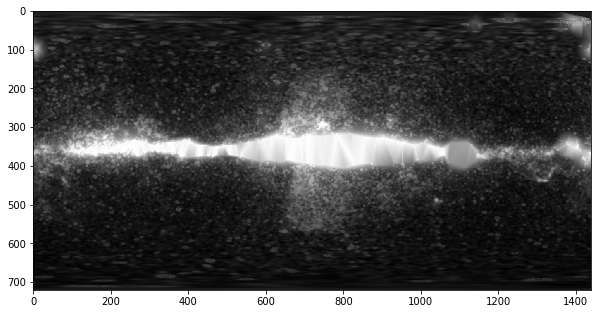

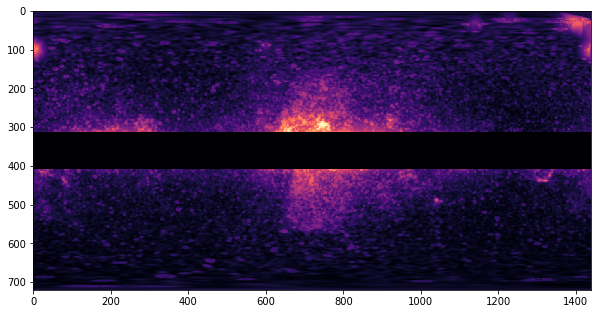

In [479]:
fermi_cut = fermi.copy()
fermi_cut[out_range_indices] = 0
plt.imshow(fermi)
plt.show()
plt.imshow(fermi_cut, cmap = 'magma')
plt.show()

**Using the method shown above with the mask you created to select the sub-set of sky pixels that are greater than $12^{\circ}$ away from the Galactic plane, fit the dust and synchrotron templates to the gamma-ray map by solving the Normal Equation using the linear algebra solution for only those pixels.**

In [480]:
# x1 = dusty_cut.flatten()
# x2 = synchy_cut.flatten()
# x3 = dusty_cut.flatten()

x1 = fermi.flatten()
x3 = synchy_cut.flatten()
x2 = dusty_cut.flatten()
y = fermi.flatten()

P = np.array([np.ones_like(x1), x2, x3]).T
PTy = np.dot(P.T, fermi.flatten())
PTP = np.dot(P.T, P)
PTPi = np.linalg.inv(PTP)
avec = np.dot(PTPi, PTy)

print("avec = {0}\n".format(avec))

avec = [ 0.21846569  9.04100923 -2.26907115]



MSE : 0.043323261562400094



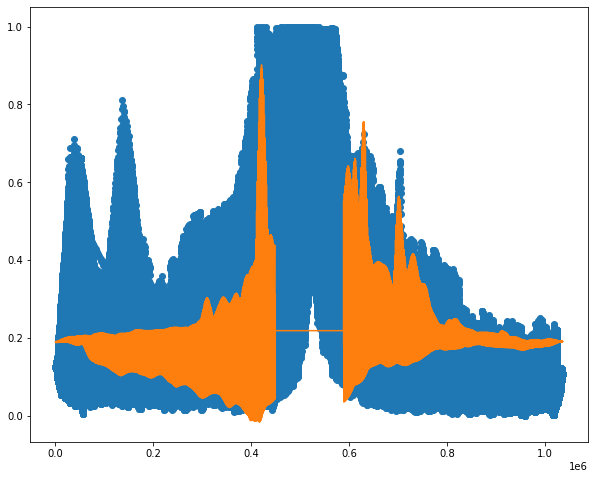

In [481]:


model = avec[0] + avec[1] * x2 + avec[2] * x3
mse = np.mean((y - model)**2)
print("MSE : {0}\n".format(mse))

# -- plot it
fig, ax = plt.subplots()
ax.plot(y, "o")
ax.plot(model)
fig.show()

In [487]:
print('my third paramater is being underestimated')

my third paramater is being underestimated


In [485]:
model = avec[0] + avec[1] * x2 + (avec[2]+4) * x3

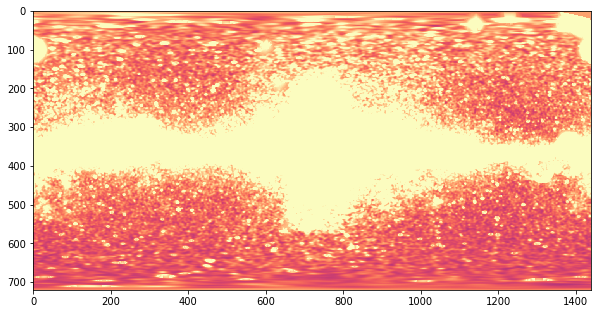

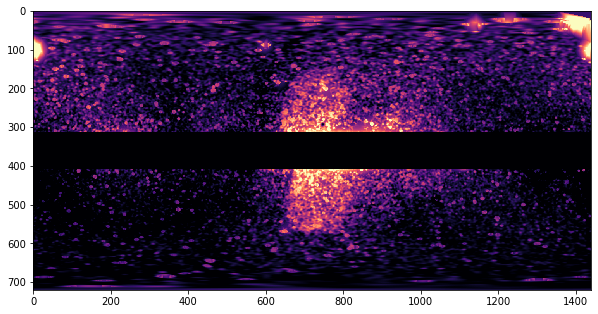

In [486]:
#definitely want imshow, which cmeans I definitely want a x by y arrray size
plt.imshow(fermi, cmap = 'magma')
plt.clim(-.2, .2)
plt.show()

resid = fermi_cut - model.reshape(720, 1440)
plt.imshow(resid, cmap = 'magma')
plt.clim(-.2, .2)

**Calculate the residuals as described in the introduction and display them with the mask, setting `cmap` to be "magma", and the `clims` to be `-0.2` to `0.2`.**  If everything has gone well, your residuals should look like the image below.

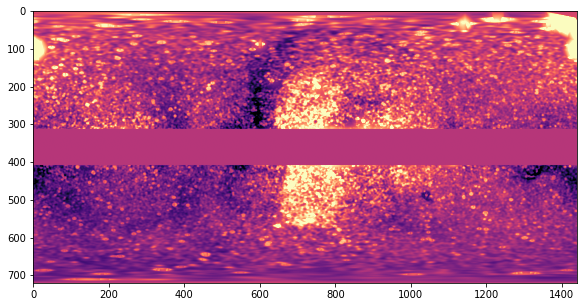

<b>Identify the location of the tip of the southern "edge" (the edge below the Galactic plane) of the Haze/Bubbles using two methods from class:

1. Gaussian differencing

2. Application of a Sobel filter to a median filtered version of the residuals

making sure to adjust the filter widths to a reasonable size to isolate the Southern edge and <u>justifying your choice</u>.</b>

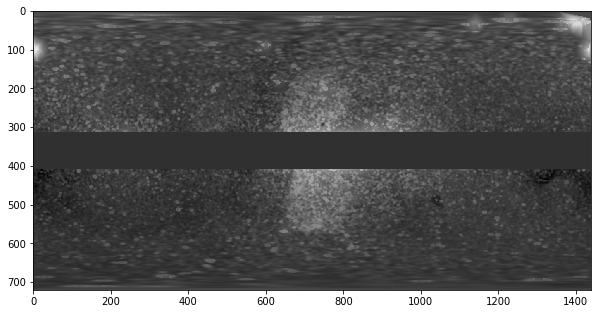

In [488]:
residual2 = resid.copy()
#residual2[310:410] = 0
plt.imshow(residual2)

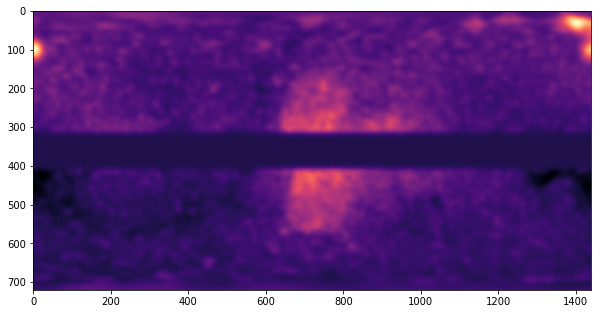

In [489]:
plt.imshow(gf(residual2, 7), cmap = 'magma')

wid and cutoff chosen through repeated manual implementation


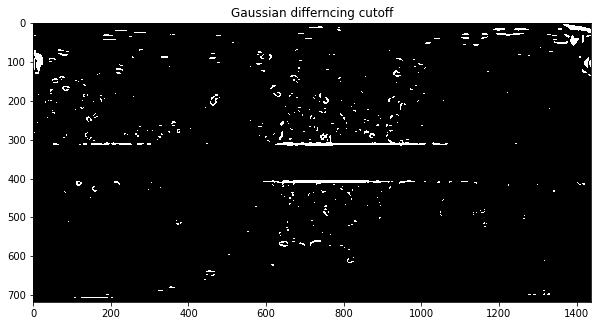

In [502]:
wid = 2.9
residual_gf = gf(residual2, wid)
hor = residual_gf[1:-1, 1:-1] - residual_gf[1:-1, :-2]
ver = residual_gf[1:-1, 1:-1] - residual_gf[:-2, 1:-1]
tot = np.sqrt(hor**2 + ver**2)

# -- show it
plt.imshow(tot > .018)
plt.title('Gaussian differncing cutoff')
print('wid and cutoff chosen through repeated manual implementation')

In [ ]:
print('bottom cutoff looks like it is at 550')

this, did not work


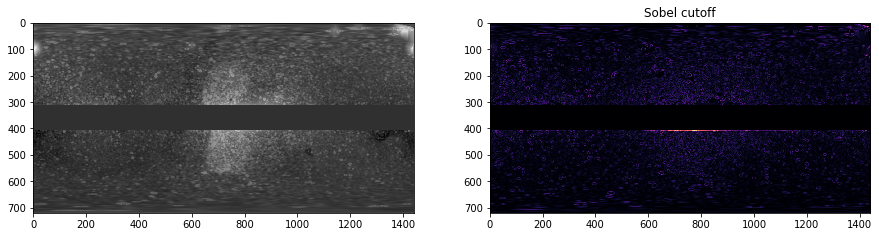

In [512]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as iio
from scipy.ndimage.filters import gaussian_filter as gf

from scipy.ndimage.filters import sobel
res_med = np.median(residual2)
res_filt = residual2 - res_med
Lx = sobel(residual2, axis=1)
Ly = sobel(residual2, axis=0)
LL = np.sqrt(Lx**2 + Ly**2)

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(residual2)
ax[1].imshow(LL, cmap = 'magma')
fig.show()
plt.title('Sobel cutoff')
print('this, did not work')

**Assuming that the Haze/Bubbles are centered at the Galactic center, how tall are they in kiloparsec?**

In [514]:
height = 550-(720/2)
print('galaxy is 1440 units wide, Earth is 8 kpc away, Earth is 2/3 of the way, galaxy is approx. 12x2=24 kpc wide')
print('%s units per kpc' % (1440/24))
print('%s kpc tall from top to middle' % (height/60))

galaxy is 1440 units wide, Earth is 8 kpc away, Earth is 2/3 of the way, galaxy is approx. 12x2=24 kpc wide
60.0 units per kpc
3.1666666666666665 kpc tall from top to middle
